# Overview
- nb002のモデルを使って後処理を考える

In [1]:
# gitのhash
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

c779faa


# Const

In [2]:
# basic
DEBUG = False
NB = '010'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
DIR_MODEL = f'../data_ignore/output_nb/nb002/'
SAVE_DIR = f'../data_ignore/output_nb/nb010/'

In [3]:
settings_str = """
globals:
  seed: 2020
  device: cuda
  num_epochs: 45

dataset:
  name: 
  params:
    
split:
  name: KFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 512
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 512
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: 
  params:

loss:
  name: BCELoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.005

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [4]:
import os
import time
import yaml
import random
import numpy as np
import pandas as pd
from glob import glob
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [5]:
import warnings
warnings.filterwarnings('ignore')

# My func

In [6]:
def preprocess(df_):
    df = df_.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
#     df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
    del df['sig_id']
    return df

def remove_ctl_cp(features_, target_):
    features = features_.copy()
    target = target_.copy()
#     bools = features['cp_type'] != 'ctl_vehicle'
    bools = features['cp_type'] != 1
    features = features[bools].reset_index(drop=True)
    features = features.drop(['cp_type'], axis=1).values
    target = target[bools].reset_index(drop=True).values
    return features, target

def add_ctl_cp_oof(oof):
    oof_new = np.zeros_like(train_targets).astype(float)
    bools = train_features['cp_type'] != 'ctl_vehicle'
    oof_new[bools, :] = oof
    return oof_new

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def get_model(length, model_path):
    model = MoaModel(length).to('cuda')
    
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    
    return model 

def mean_log_loss(y_true, y_pred):
    metrics = []
    for i, target in enumerate(target_cols):
        metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
    return np.mean(metrics)

In [7]:
class MoaModel(nn.Module):
    def __init__(self, num_columns):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_columns)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_columns, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.sigmoid(self.dense3(x))
        
        return x

In [8]:
class MoaDataset(Dataset):
    def __init__(self, df, targets, mode):
        self.mode = mode
        self.df = df
#         self.targets = targets
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.df[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'val':
            return torch.FloatTensor(self.df[idx]), 0

class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx])

In [9]:
def get_epoch_loss_score(model, device, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            pred = model(x)
            loss = criterion(pred, y)
        running_loss += loss.item() / len(valid_loader)
        targets.append(y)
        preds.append(pred)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    _mean_log_loss = mean_log_loss(targets, preds)
    return running_loss, _mean_log_loss, preds

# Preparation

set

In [10]:
settings = yaml.safe_load(settings_str)
seed_everything(settings['globals']['seed'])
sns.set()
sns.set_context('talk')

In [11]:
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

<br>

load dataset

In [12]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
# test_features = pd.read_csv(PATH_TEST)

# ss = pd.read_csv(PATH_SUB)

In [13]:
if DEBUG:
    print(':: debug mode ::')
    train_features = train_features.iloc[::100, :]
    train_targets = train_targets.iloc[::100, :]
#     test_features = test_features.iloc[::100, :]

<br>

preprocess

In [14]:
mask_trt = train_features['cp_type'] == 'trt_cp'
train = preprocess(train_features)
# test = preprocess(test_features).values

del train_targets['sig_id']

target_cols = [col for col in train_targets.columns]
train, targets = remove_ctl_cp(train, train_targets)
# train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True).values
# train = train.loc[train['cp_type']==0].reset_index(drop=True).values

In [15]:
print(f'train shape:         {train.shape}')
# print(f'test shape:          {test.shape}')
print(f'train_targets shape: {targets.shape}')

train shape:         (21948, 874)
train_targets shape: (21948, 206)


In [16]:
path_model_list = sorted(glob(f'{DIR_MODEL}/*'))
path_model_list

['../data_ignore/output_nb/nb002/Fold1of5.pt',
 '../data_ignore/output_nb/nb002/Fold2of5.pt',
 '../data_ignore/output_nb/nb002/Fold3of5.pt',
 '../data_ignore/output_nb/nb002/Fold4of5.pt',
 '../data_ignore/output_nb/nb002/Fold5of5.pt']

# Inference

In [17]:
n_splits = settings['split']['params']['n_splits']
splitter = KFold(**settings['split']['params'])
device = settings['globals']['device']
criterion = criterion_ = nn.__getattribute__(
    settings['loss']['name'])(**settings['loss']['params'])
# val_set = MoaDataset(train, targets, mode='train')
# valid_loader = DataLoader(val_set, **settings['loader']['val'])

In [46]:
%%time
oof = np.zeros_like(targets).astype(float)
for n, (idx_trn, idx_val) in enumerate(splitter.split(train, targets)):
    X_trn, X_val = train[idx_trn], train[idx_val]
    y_trn, y_val = targets[idx_trn], targets[idx_val]

    val_set = MoaDataset(X_val, y_val, mode='train')
    val_loader = DataLoader(val_set, **settings['loader']['val'])

    model = get_model(train.shape[1], path_model_list[n])
    optimizer = optim.__getattribute__(settings['optimizer']['name'])(
        model.parameters(), **settings['optimizer']['params'])
    valid_loss, _mean_log_loss, preds = get_epoch_loss_score(model, device, val_loader, criterion)

    # result
    oof[idx_val, :] = preds
oof = add_ctl_cp_oof(oof)
mean_log_loss(train_targets.values, oof)

CPU times: user 2.8 s, sys: 2.36 s, total: 5.16 s
Wall time: 4.8 s


0.0151359400333833

# Postprcessing
- 0.3~0.7を置き換える

In [19]:
def postprocess_logloss(arr, val, low, high):
    _arr = arr.copy()
    mask = (low <= arr) & (arr <= high)
    _arr[mask] = val
    return _arr

In [270]:
_oof = oof.copy()
_oof_trt = _oof[mask_trt]

for val in [0.9, 0.8, 0.5, 0.4, 0.2, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    _oof_trt_post = postprocess_logloss(_oof_trt, val, 0.3, 0.7)
    _oof[mask_trt] = _oof_trt_post
    _log_loss = mean_log_loss(train_targets.values, _oof)
    print(f'val={val:.1e}, logloss={_log_loss:.6f}')

val=9.0e-01, logloss=0.015222
val=8.0e-01, logloss=0.015172
val=5.0e-01, logloss=0.015135
val=4.0e-01, logloss=0.015141
val=2.0e-01, logloss=0.015182
val=1.0e-01, logloss=0.015238
val=1.0e-02, logloss=0.015450
val=1.0e-03, logloss=0.015671
val=1.0e-04, logloss=0.015892
val=1.0e-05, logloss=0.016113


---> あんまりよくならへんなー

# Analysis
- target==1の時のoofの分布

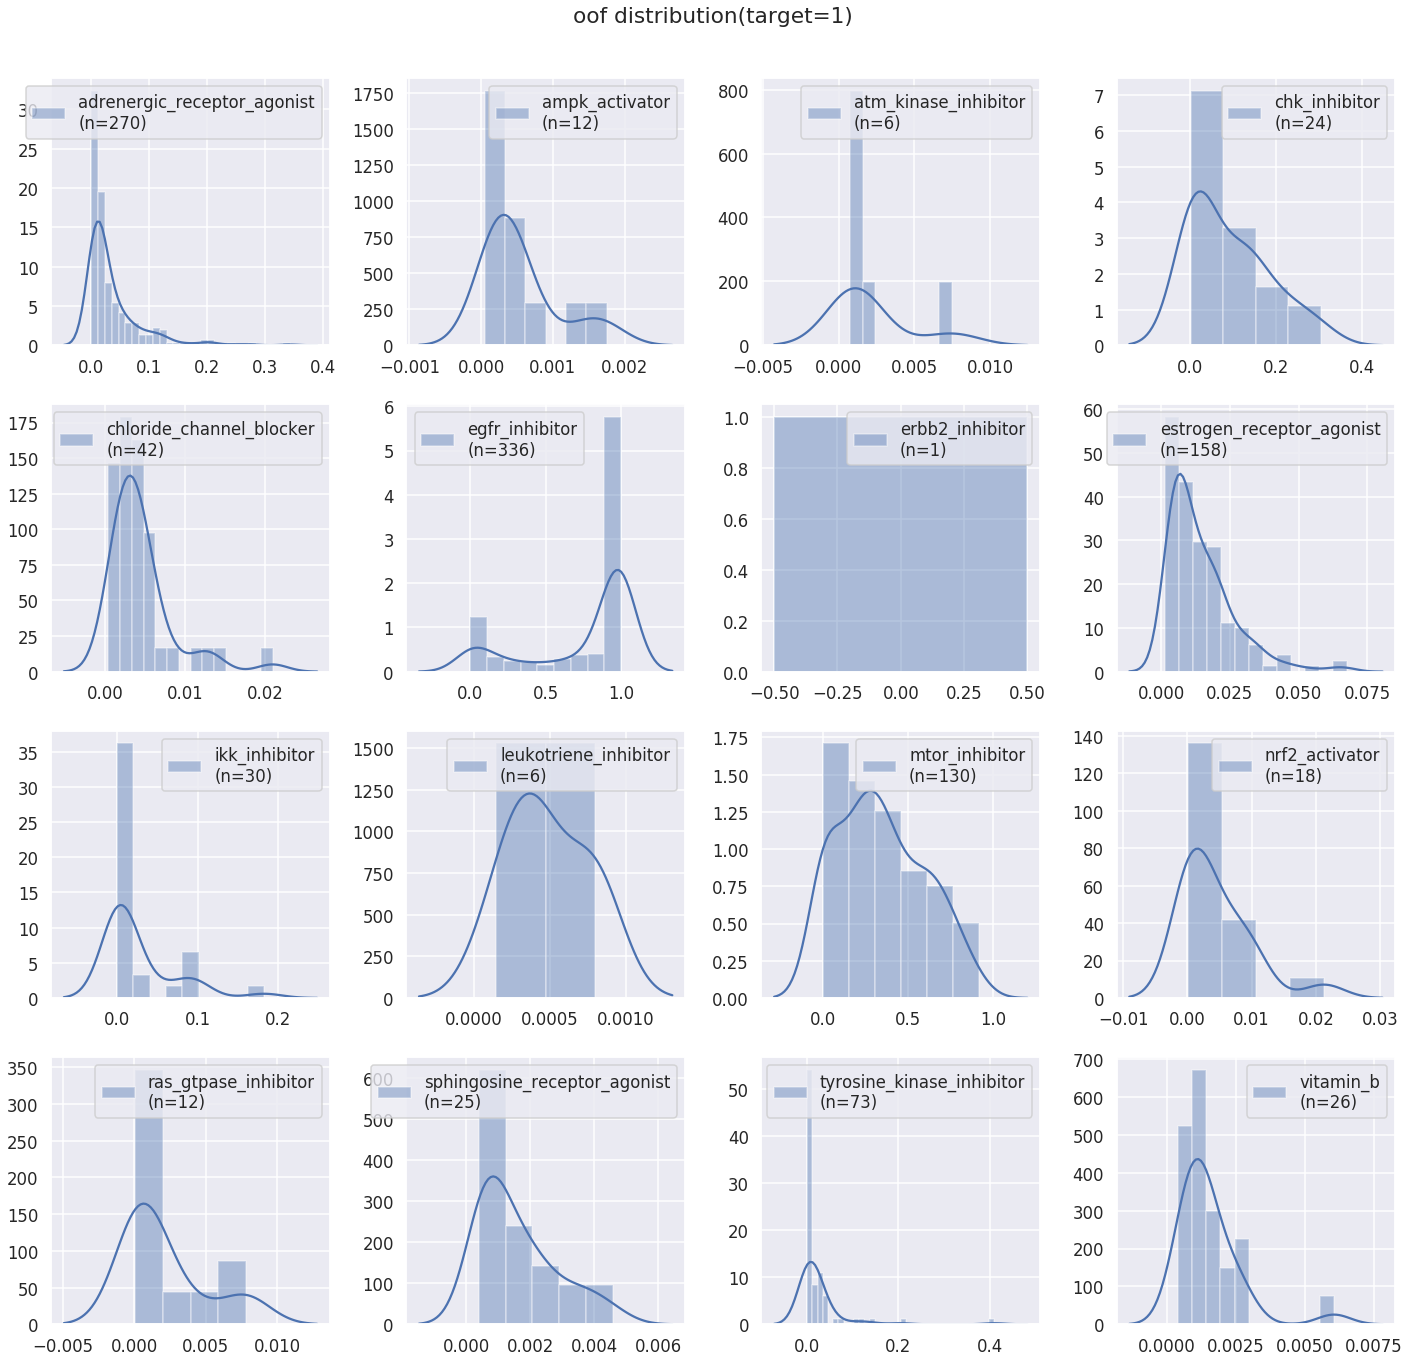

In [269]:
randint = sorted(np.random.randint(0, len(target_cols)))

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('oof distribution(target=1)')
axs = axs.ravel()
for i_ax, idx in enumerate(randint):
    target = train_targets.iloc[:, idx]
    name = target_cols[idx]
    n_target = np.sum(target)

    oof_1 = oof[:, idx][target==1]
    sns.distplot(oof_1, label=f'{name}\n(n={n_target})', ax=axs[i_ax])

    # plt.xlim(-0.01, 1)
#     axs[i_ax].set_title('distribution oof')
    axs[i_ax].legend()

<br>

nの分布は？

Text(0.5, 1.0, 'sum of target=1 distribution')

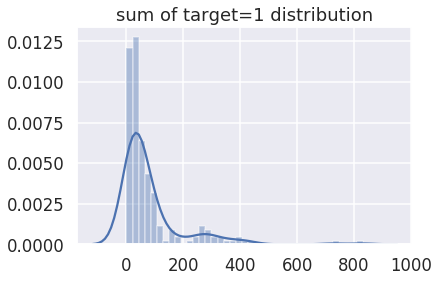

In [275]:
sns.distplot(train_targets.sum(axis=0).values)
plt.title('sum of target=1 distribution')

<br>

n と loglossの関係

In [288]:
n_list = np.array(train_targets.sum(axis=0).values)
log_loss_cols = np.array([log_loss(train_targets.iloc[:, i], oof[:, i]) for i in range(len(target_cols))])

Text(0, 0.5, 'logloss per target cols')

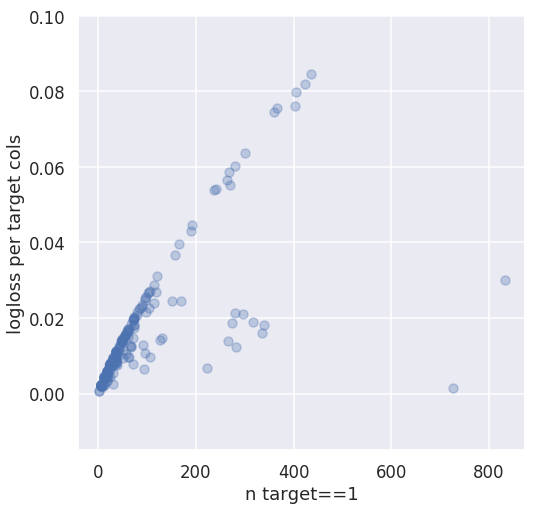

In [287]:
plt.figure(figsize=(8, 8))
plt.scatter(n_list, log_loss_cols, alpha=0.3)
plt.xlabel('n target==1')
plt.ylabel('logloss per target cols')

<br>

外れ値のcolumnをチェック

In [299]:
mask_outlier = (n_list > 200) & (log_loss_cols < 0.04)
np.array(target_cols)[mask_outlier]

array(['cdk_inhibitor', 'egfr_inhibitor', 'flt3_inhibitor',
       'glucocorticoid_receptor_agonist', 'hmgcr_inhibitor',
       'kit_inhibitor', 'nfkb_inhibitor', 'pdgfr_inhibitor',
       'proteasome_inhibitor', 'raf_inhibitor', 'tubulin_inhibitor'],
      dtype='<U47')

----

In [332]:
mask_outlier = (n_list > 200) & (log_loss_cols > 0.04)
outlier_name = np.array(target_cols)[mask_outlier]
outlier_name

array(['acetylcholine_receptor_antagonist', 'adrenergic_receptor_agonist',
       'adrenergic_receptor_antagonist', 'calcium_channel_blocker',
       'cyclooxygenase_inhibitor', 'dna_inhibitor',
       'dopamine_receptor_antagonist', 'glutamate_receptor_antagonist',
       'histamine_receptor_antagonist', 'phosphodiesterase_inhibitor',
       'serotonin_receptor_agonist', 'serotonin_receptor_antagonist',
       'sodium_channel_inhibitor'], dtype='<U47')

In [341]:
oof_.shape, train_features.shape, train.shape

((23814, 206), (23814, 876), (21948, 874))

In [487]:
idx = 1
mask_col_outlier = np.array(target_cols) == outlier_name[idx]
oof_col_outlier = oof[mask_trt][:, mask_col_outlier].ravel()
target_col_outlier = targets[:, mask_col_outlier].ravel()
print(f'n_target==1: {n_list[mask_col_outlier]}')
original_loss = log_loss(target_col_outlier, oof_col_outlier)
original_loss

n_target==1: [270]


0.059921302947451335

In [467]:
n_list[mask_outlier]

array([301])

In [444]:
logloss_list = []
log_space = np.logspace(-4, -0.5, 100)
for log in log_space:
    oof_const = np.full(len(oof_col_outlier), log)
    loss = log_loss(target_col_outlier, oof_const)
    logloss_list.append(log_loss(target_col_outlier, oof_const))

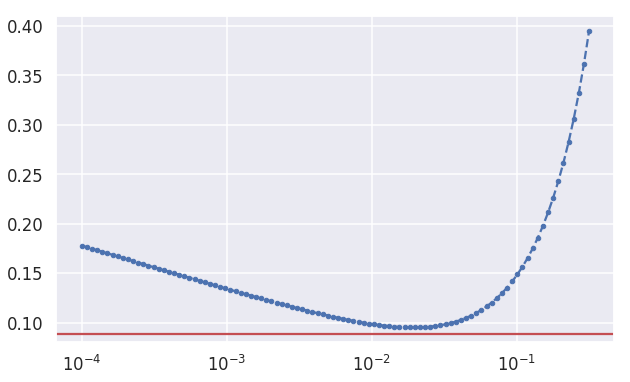

In [445]:
plt.figure(figsize=(10, 6))
plt.plot(log_space, logloss_list, '--.')
plt.axhline(original_loss, color='r')
plt.xscale('log')

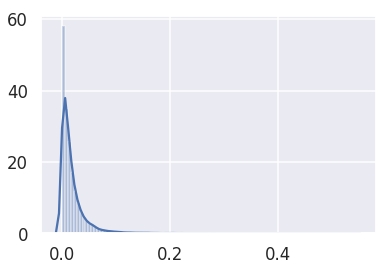

In [446]:
sns.distplot(oof_col_outlier, bins=100)
# plt.xlim(-0.01, 0.1)

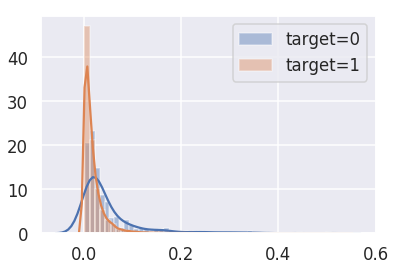

In [447]:
mask = target_col_outlier == 1
sns.distplot(oof_col_outlier[mask], label='target=0')
sns.distplot(oof_col_outlier[~mask], label='target=1')
# plt.xlim(-0.01, 0.1)
plt.legend()

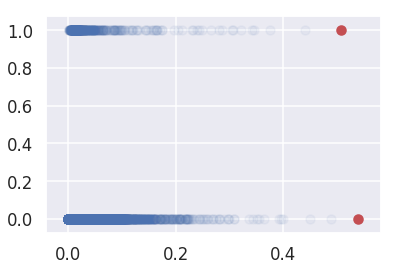

In [455]:
mask_high = oof_col_outlier > 0.5
plt.scatter(oof_col_outlier, target_col_outlier, alpha=0.05)
plt.scatter(oof_col_outlier[mask_high], target_col_outlier[mask_high], color='r')

2